# Generate Particle Ephemeris

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord

from jorbit.utils.states import KeplerianState
from jorbit.data.constants import SPEED_OF_LIGHT
from jorbit import Particle

The easiest way to see how a particle appears on-sky over time is through the `Particle` class. There are a number of ways to create a `Particle`: using the values from Horizons as queried today, the following three methods are all equivalent:

In [2]:
# query Horizons for the state of a particle at a single epoch
p = Particle.from_horizons(name="274301", time=Time("2025-01-01"))

# directly supply state vectors in barycentric ICRS coordinates, units of AU and AU/day
p = Particle(
    name="(274301) Wikipedia",
    x=jnp.array([-2.003779703686627, 1.780533558134481,0.5203350526739642]),
    v=jnp.array([-0.006668390915419885,-0.006621147093559814,-0.002036640485149475]),
    time=Time("2025-01-01")
)

# use ecliptic orbital elements
k = KeplerianState(
    semi=jnp.array([2.3785863410573236]),
    ecc=jnp.array([0.14924976664546713]),
    inc=jnp.array([6.733641114294506]),
    Omega=jnp.array([183.37291068678854]),
    omega=jnp.array([140.26341029272996]),
    nu=jnp.array([173.59627946476093]),
    time=Time("2025-01-01").tdb.jd,
    acceleration_func_kwargs={"c2": SPEED_OF_LIGHT**2}
)
p = Particle(name="(274301) Wikipedia", state=k)

Now that we have a `Particle`, we can track its motion across the sky using the `ephemeris` method:

In [3]:
eph = p.ephemeris(
    times=Time(["2025-01-01", "2025-01-02", "2025-01-03"]),
    observer="kitt peak"
)
eph

<SkyCoord (ICRS): (ra, dec) in deg
    [(153.7296451 , 3.87795416), (153.68822683, 3.87901592),
     (153.64036289, 3.88300908)]>

Under the hood, this runs an N-body simulation that accounts for PPN perturbations from the planets and Newtonian perturbations from the 16 most massive asteroids. The exact acceleration function used can be set via the "gravity" keyword in `Particle`. Note that the first time `.ephemeris` is called will be much slower than subsequent calls since we need to JIT-compile some of the integration code.

For fun, let's look at the predicted difference between observing this object from two different nearby observatories:

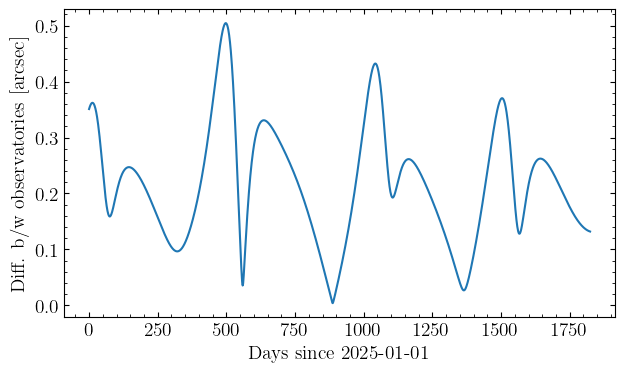

In [4]:
kp_observations = p.ephemeris(
    times=Time("2025-01-01") + jnp.arange(0, 365 * 5, 1) * u.day, observer="kitt peak"
)
palomar_observations = p.ephemeris(
    times=Time("2025-01-01") + jnp.arange(0, 365 * 5, 1) * u.day, observer="palomar"
)

fig, ax = plt.subplots()
ax.plot(
    jnp.arange(0, 365 * 5, 1), kp_observations.separation(palomar_observations).to(u.arcsec)
)
ax.set(
    xlabel="Days since 2025-01-01",
    ylabel="Diff. b/w observatories [arcsec]",
);

Obviously we wouldn't be able to observe the same object every day for so many months in a row, but still, interesting to play with! Here's what the ephemeris looks like for a single observatory:

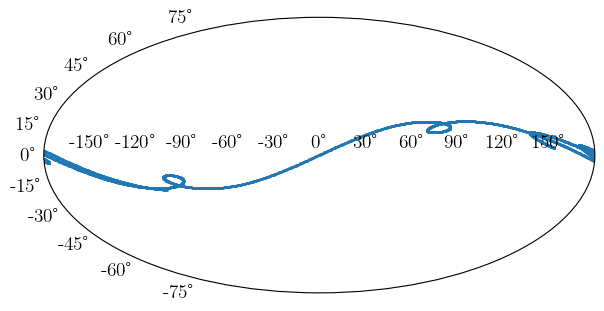

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    kp_observations.ra.wrap_at(180 * u.deg).radian,
    kp_observations.dec.radian,
    s=1,
    label="Kitt Peak",
)